In [26]:
import glob
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

col_names = ["func", "start", "end", "filename", "worker", "thread", "process"]

In [27]:
def avg_func_time(folder):
    pd_list = [pd.read_csv(filename, names=col_names) for filename in glob.glob(folder)]
    df = pd.concat(pd_list, axis=0, ignore_index=True)
    df["runtime"] = df.end - df.start
    return df.groupby("func").mean()["runtime"]

def func_count(folder):
    pd_list = [pd.read_csv(filename, names=col_names) for filename in glob.glob(folder)]
    df = pd.concat(pd_list, axis=0, ignore_index=True)
    return df.groupby("func").count()["filename"]

def concurrent_threads(folder, granularity=100):
    thread = "process" if "spark" in folder  else "thread"
    def func_(filename):
        df = pd.read_csv(filename, names=col_names)

        df["active"] = df.apply(
            lambda x: list(
                np.linspace(
                    round(x.start),
                    round(x.end),
                    granularity,
                )
            ),
            axis=1)
        df = df.explode("active")

        return df.groupby(["active", thread]).count() \
            .reset_index(thread).groupby(["active"]).count()
    
    for filename in glob.glob(folder):
        print(filename)

        rv = func_(filename)
        rv.reset_index().plot.scatter("active", thread, s=2)
        plt.show()
        pprint(rv[thread].describe())

In [3]:
folder = "../ccpe-debug-64-32mb/benchmarks/spark:kmeans:n_worker=8:block_size=5000:iterations=3/*"
avg_func_time(folder), func_count(folder)

(func
 classify_block      7.427689
 dump                1.020030
 get_labels          1.687419
 load                7.935378
 update_centroids    0.133224
 Name: runtime, dtype: float64,
 func
 classify_block       2500
 dump                 2500
 get_labels          30000
 load                 7500
 update_centroids    30000
 Name: filename, dtype: int64)

In [4]:
folder = "../ccpe-debug-64-32mb/benchmarks/dask:kmeans:n_worker=8:block_size=5000:iterations=3/*"
avg_func_time(folder), func_count(folder)

(func
 classify_block      11.524744
 dump                 0.214764
 get_labels           1.198153
 load                 3.314458
 update_centroids     0.075501
 Name: runtime, dtype: float64,
 func
 classify_block       2500
 dump                 2500
 get_labels          30003
 load                15001
 update_centroids    30003
 Name: filename, dtype: int64)

# Spark concurrent process

../ccpe-debug-64-32mb/benchmarks/spark:kmeans:n_worker=8:block_size=5000:iterations=3/summary-4cbe795d-9139-11ec-b1a8-4cd98faa323f.csv


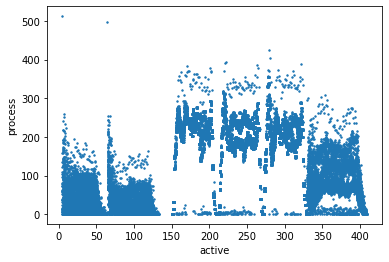

count    40242.000000
mean       109.951369
std         90.572372
min          1.000000
25%         25.000000
50%         76.000000
75%        197.000000
max        512.000000
Name: process, dtype: float64


In [28]:
folder = "../ccpe-debug-64-32mb/benchmarks/spark:kmeans:n_worker=8:block_size=5000:iterations=3/*"
concurrent_threads(folder)

../ccpe-debug-64-32mb/benchmarks/spark:kmeans:n_worker=4:block_size=5000:iterations=3/summary-11ac7618-9136-11ec-a81f-4cd98faa323f.csv


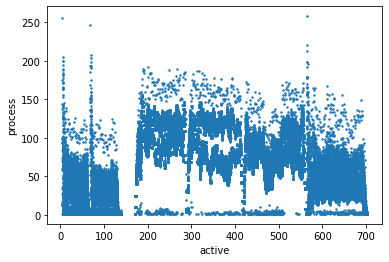

count    67700.000000
mean        63.473368
std         36.303684
min          1.000000
25%         32.000000
50%         64.000000
75%         90.000000
max        258.000000
Name: process, dtype: float64


In [29]:
folder = "../ccpe-debug-64-32mb/benchmarks/spark:kmeans:n_worker=4:block_size=5000:iterations=3/*"
concurrent_threads(folder)

../ccpe-debug-64-32mb/benchmarks/spark:kmeans:n_worker=2:block_size=5000:iterations=3/summary-a5b754d2-913b-11ec-ab46-4cd98faa323f.csv


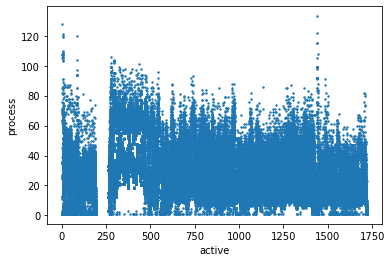

count    163763.000000
mean         26.311994
std          15.632445
min           1.000000
25%          15.000000
50%          22.000000
75%          35.000000
max         133.000000
Name: process, dtype: float64


In [30]:
folder = "../ccpe-debug-64-32mb/benchmarks/spark:kmeans:n_worker=2:block_size=5000:iterations=3/*"
concurrent_threads(folder)

# Dask concurrent thread

../ccpe-debug-64-32mb/benchmarks/dask:kmeans:n_worker=8:block_size=5000:iterations=3/summary-796888ad-913a-11ec-ae71-4cd98faa323f.csv


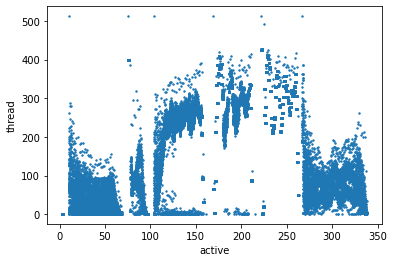

count    30537.000000
mean       144.518191
std        122.948563
min          1.000000
25%         35.000000
50%         92.000000
75%        258.000000
max        512.000000
Name: thread, dtype: float64


In [31]:
folder = "../ccpe-debug-64-32mb/benchmarks/dask:kmeans:n_worker=8:block_size=5000:iterations=3/*"
concurrent_threads(folder)

../ccpe-debug-64-32mb/benchmarks/dask:kmeans:n_worker=4:block_size=5000:iterations=3/summary-d4b1c935-9137-11ec-b5a1-4cd98faa323f.csv


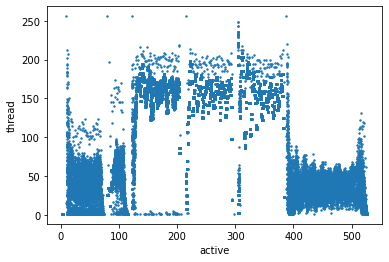

count    48881.000000
mean        91.540926
std         64.777330
min          1.000000
25%         30.000000
50%         67.000000
75%        158.000000
max        256.000000
Name: thread, dtype: float64


In [32]:
folder = "../ccpe-debug-64-32mb/benchmarks/dask:kmeans:n_worker=4:block_size=5000:iterations=3/*"
concurrent_threads(folder)

../ccpe-debug-64-32mb/benchmarks/dask:kmeans:n_worker=2:block_size=5000:iterations=3/summary-a71bbef7-9133-11ec-b20b-4cd98faa323f.csv


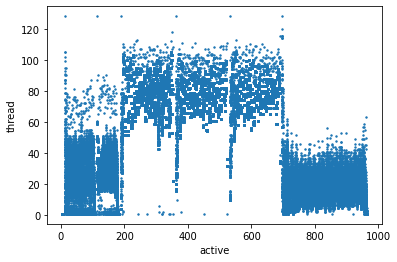

count    91463.000000
mean        50.601489
std         31.126080
min          1.000000
25%         20.000000
50%         58.000000
75%         79.000000
max        128.000000
Name: thread, dtype: float64


In [33]:
folder = "../ccpe-debug-64-32mb/benchmarks/dask:kmeans:n_worker=2:block_size=5000:iterations=3/*"
concurrent_threads(folder)

# Test for concurrent thread function

In [11]:
df = pd.concat([pd.DataFrame({"start": np.arange(0, 1000, x)}).assign(base = x) for x in [1, 2, 3, 5]])

df["active"] = df.apply(lambda x:list(np.linspace(round(x.start), round(x.start), 1)), axis=1)
df = df.explode("active")

rv = df.groupby(["active", "base"]).count() \
    .reset_index("base").groupby(["active"]).count()

out_data = rv.base.values
for i in range(1000):
    count = 1
    if i % 2 == 0:
        count += 1
    if i % 3 == 0:
        count += 1
    if i % 5 == 0:
        count += 1
        
    assert count == out_data[i]